In [1]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import csv 
import networkx as nx
from random import sample
import time

In [40]:
# Barabasi Albert graph for test
N = 1000
m1 = 15
m2 = 3
p = 0.1

G = nx.generators.random_graphs.dual_barabasi_albert_graph(N,m1,m2,p)


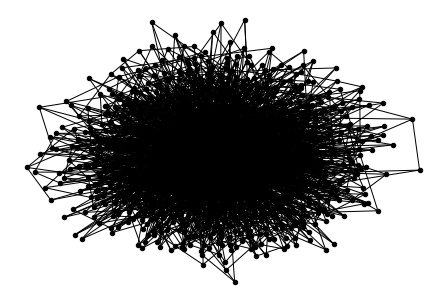

In [41]:
# show graph to get an idea
options = {
     'node_color': 'black',
     'node_size': 20,
     'width': 1,
    }

nx.draw(G, font_weight='bold', **options)
plt.show()


In [56]:
#preparing inputs for rigel
landmark_cnt = 100
landmarks = sample(list(G.nodes()), landmark_cnt)
distance_matrix = [[-1 for i in range(N)] for j in range(landmark_cnt)]
for i in range(landmark_cnt):
    node = landmarks[i]
    path_lengths = nx.single_source_shortest_path_length(G, node)
    for j in range(N):
        distance_matrix[i][j] = int(path_lengths[j])

In [70]:
# write out input for Rigel
mat = np.matrix(distance_matrix)
with open('l.txt','wb') as f:
    for line in mat:
        np.savetxt(f, line, fmt='%-4d')
f.close()

ValueError: write to closed file

In [64]:
# write out input for Rigel
with open('r.txt', 'w') as f:
    for node in landmarks:
        f.write('%s\n' % node)
f.close()

In [66]:
# write out input for Rigel
with open('0.ord', 'w') as f:
    for i in range(N):
        if not i in landmarks:
            f.write('%s\n' % i)
f.close()

In [1]:
nx.single_source_shortest_path_length(G, 100)[200]

NameError: name 'nx' is not defined

In [ ]:
### ROADMAP PENNSYLVANIA

In [2]:
RMPS = nx.read_edgelist("roadnetPA.txt", nodetype=int)

In [3]:
#largest connected component
RMPSccs = sorted(nx.connected_components(RMPS), key=len, reverse=True)
RMPScc = RMPS.subgraph(RMPSccs[0])

In [10]:
np.random.seed(1337)
M = 100000
random_nodes = list(RMPS.subgraph(RMPScc).nodes())[0:100000]
G = RMPS.subgraph(random_nodes)
Gccs = sorted(nx.connected_components(G), key=len, reverse=True)
Gcc = G.subgraph(Gccs[0])

In [14]:
mapping = dict(zip(Gcc, range(len(Gcc.nodes))))
Gcc = nx.relabel_nodes(Gcc, mapping)

In [15]:
#preparing inputs for rigel
nodes = list(Gcc.nodes())
N = len(nodes)
landmark_cnt = 100
landmarks = sample(nodes, landmark_cnt)
distance_matrix = [[-1 for i in range(N)] for j in range(landmark_cnt)]
#distance_matrix = dict()
for i in range(landmark_cnt):
    #distance_matrix[i] = dict()
    start_time = time.time()
    print('landmark ', i, ' calculating...')
    node = landmarks[i]
    path_lengths = nx.single_source_shortest_path_length(Gcc, node)
    for j in nodes:
        distance_matrix[i][j] = int(path_lengths[j])
    print("landmark ", i," finished in --- %s seconds ---" % (time.time() - start_time))

landmark  0  calculating...
landmark  0  finished in --- 0.12497186660766602 seconds ---
landmark  1  calculating...
landmark  1  finished in --- 0.11928939819335938 seconds ---
landmark  2  calculating...
landmark  2  finished in --- 0.10878920555114746 seconds ---
landmark  3  calculating...
landmark  3  finished in --- 0.124969482421875 seconds ---
landmark  4  calculating...
landmark  4  finished in --- 0.10830187797546387 seconds ---
landmark  5  calculating...
landmark  5  finished in --- 0.10930895805358887 seconds ---
landmark  6  calculating...
landmark  6  finished in --- 0.1239016056060791 seconds ---
landmark  7  calculating...
landmark  7  finished in --- 0.12364840507507324 seconds ---
landmark  8  calculating...
landmark  8  finished in --- 0.1216423511505127 seconds ---
landmark  9  calculating...
landmark  9  finished in --- 0.10349845886230469 seconds ---
landmark  10  calculating...
landmark  10  finished in --- 0.12020730972290039 seconds ---
landmark  11  calculati

landmark  93  finished in --- 0.12151932716369629 seconds ---
landmark  94  calculating...
landmark  94  finished in --- 0.10935688018798828 seconds ---
landmark  95  calculating...
landmark  95  finished in --- 0.1465311050415039 seconds ---
landmark  96  calculating...
landmark  96  finished in --- 0.13205528259277344 seconds ---
landmark  97  calculating...
landmark  97  finished in --- 0.14548707008361816 seconds ---
landmark  98  calculating...
landmark  98  finished in --- 0.13061928749084473 seconds ---
landmark  99  calculating...
landmark  99  finished in --- 0.12007999420166016 seconds ---


In [93]:
## FROM HERE IT IS THE ORIGINAL DATASET (largest cmoponent)

mapping = dict(zip(RMPScc, range(len(RMPScc.nodes))))
RMPScc = nx.relabel_nodes(RMPScc, mapping)

In [95]:
#preparing inputs for rigel
nodes = list(RMPScc.nodes())
N = len(nodes)
landmark_cnt = 100
landmarks = sample(nodes, landmark_cnt)
distance_matrix = [[-1 for i in range(N)] for j in range(landmark_cnt)]
#distance_matrix = dict()
for i in range(landmark_cnt):
    #distance_matrix[i] = dict()
    start_time = time.time()
    print('landmark ', i, ' calculating...')
    node = landmarks[i]
    path_lengths = nx.single_source_shortest_path_length(RMPScc, node)
    for j in nodes:
        distance_matrix[i][j] = int(path_lengths[j])
    print("landmark ", i," finished in --- %s seconds ---" % (time.time() - start_time))

landmark  0  calculating...
landmark  0  finished in --- 1.6377153396606445 seconds ---
landmark  1  calculating...
landmark  1  finished in --- 1.6166908740997314 seconds ---
landmark  2  calculating...
landmark  2  finished in --- 1.513000726699829 seconds ---
landmark  3  calculating...
landmark  3  finished in --- 1.4783613681793213 seconds ---
landmark  4  calculating...
landmark  4  finished in --- 1.6306395530700684 seconds ---
landmark  5  calculating...
landmark  5  finished in --- 1.629654884338379 seconds ---
landmark  6  calculating...
landmark  6  finished in --- 1.5214283466339111 seconds ---
landmark  7  calculating...
landmark  7  finished in --- 1.5366547107696533 seconds ---
landmark  8  calculating...
landmark  8  finished in --- 1.5249764919281006 seconds ---
landmark  9  calculating...
landmark  9  finished in --- 1.6844770908355713 seconds ---
landmark  10  calculating...
landmark  10  finished in --- 1.5920593738555908 seconds ---
landmark  11  calculating...
lan

landmark  92  finished in --- 1.5907361507415771 seconds ---
landmark  93  calculating...
landmark  93  finished in --- 1.526585578918457 seconds ---
landmark  94  calculating...
landmark  94  finished in --- 1.5927433967590332 seconds ---
landmark  95  calculating...
landmark  95  finished in --- 1.646303415298462 seconds ---
landmark  96  calculating...
landmark  96  finished in --- 1.623143196105957 seconds ---
landmark  97  calculating...
landmark  97  finished in --- 1.6538927555084229 seconds ---
landmark  98  calculating...
landmark  98  finished in --- 1.6443815231323242 seconds ---
landmark  99  calculating...
landmark  99  finished in --- 1.6246025562286377 seconds ---


In [16]:
# write out input for Rigel
mat = np.matrix(distance_matrix)
with open('l_PS_small.txt','wb') as f:
    for line in mat:
        np.savetxt(f, line, fmt='%-4d')
f.close()

In [17]:
# write out input for Rigel
with open('r_PS_small.txt', 'w') as f:
    for node in landmarks:
        f.write('%s\n' % node)
f.close()

In [18]:
# write out input for Rigel
with open('0.ord', 'w') as f:
    for i in range(N):
        if not i in landmarks:
            f.write('%s\n' % i)
f.close()

In [34]:
nx.shortest_path_length(Gcc,44155,65820)

110